In [359]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import seaborn as sns
import mpl_scatter_density
%matplotlib inline
sns.set_style('white')
sns.set_context('talk')

In [226]:
def l(x, c=1.0):
    return np.log2(x+1)

In [459]:
ind_cols = {'SLA' : 'Name', 'hera' : 'target_id', 'polyester' : 'transcript_id', 'kallisto' : 'target_id',\
            'salmon (Bowtie2)' : 'Name', 'salmon (STAR)' : 'Name'}
read_cols = {'SLA' : 'NumReads', 'hera' : 'est_counts', 'polyester' : 'count', 'kallisto' : 'est_counts', \
             'salmon (Bowtie2)' : 'NumReads', 'salmon (STAR)' : 'NumReads'}

def readSalmon(fn, suf):
    x = pd.read_table(fn)
    rename_dict = { v : '{}_{}'.format(v, suf) for v in x.columns.values if v != ind_cols['SLA'] }
    x = x.rename(index=str, columns=rename_dict)
    return x

def readPolyester(fn, suf):
    x = pd.read_table(fn)
    rename_dict = { v : '{}_{}'.format(v, suf) for v in x.columns.values if v != ind_cols['polyester'] }
    x = x.rename(index=str, columns=rename_dict)
    return x

def readKallisto(fn, suf):
    x = pd.read_table(fn)
    rename_dict = { v : '{}_{}'.format(v, suf) for v in x.columns.values if v != ind_cols['kallisto'] }
    x = x.rename(index=str, columns=rename_dict)
    return x

def readHera(fn, suf):
    x = pd.read_table(fn, skiprows=1, header=None, \
                      names=['temp', 'unique_map', 'length', 'eff_length', 'est_counts', 'tpm'])
    x['target_id'] = x['temp'].str.split(':').str.get(0)
    x = x.drop('temp', axis=1)
    rename_dict = { v : '{}_{}'.format(v, suf) for v in x.columns.values if v != ind_cols['hera'] }
    x = x.rename(index=str, columns=rename_dict)
    return x

In [460]:
loaders = {'SLA' : readSalmon, 'salmon (Bowtie2)' : readSalmon, 'salmon (STAR)' : readSalmon,\
           'kallisto' : readKallisto, 'hera' : readHera, 'polyester' : readPolyester}
metrics = {
    'explained var' : sklearn.metrics.explained_variance_score,
    'mean abs error' : sklearn.metrics.mean_absolute_error,
    'mean sq. error' : sklearn.metrics.mean_squared_error,
    'mean sq. log error' : sklearn.metrics.mean_squared_log_error,
    'median abs error' : sklearn.metrics.median_absolute_error,
    'r2 score' : sklearn.metrics.r2_score}

In [461]:
mrate_dict = {mrate : \
             {'hera' : '../SRR5638585_polyreads_full/quant_mutated{}/reads_95/hera_out/abundance.tsv'.format(mrate),
             'SLA' : '../SRR5638585_polyreads_full/quant_mutated{}/reads_95/salmon_out/soft_filter/quant.sf'.format(mrate),
             'salmon (Bowtie2)' : '../SRR5638585_polyreads_full/quant_mutated{}/reads_95/bowtie_out/quant.sf'.format(mrate),
             'salmon (STAR)' : '../SRR5638585_polyreads_full/quant_mutated{}/reads_95/star_out/no_option/quant.sf'.format(mrate),
             'polyester' : '../SRR5638585_polyreads_full/quant_mutated1/reads_95/truth.tsv',
             'kallisto' : '../SRR5638585_polyreads_full/quant_mutated{}/reads_95/kallisto_out/abundance.tsv'.format(mrate)} \
             for mrate in range(1,6)}

In [234]:
def loadMutData(pathdict, suff):
    m = None
    for k, v in pathdict.items():
        totsuff = '{}_{}'.format(k,suff)
        x = loaders[k](v, totsuff)
        if m is not None:
            m = pd.merge(m, x, left_on=mkey, right_on=ind_cols[k], how='outer')
        else:
            m = x
            mkey = ind_cols[k]
    return m

In [235]:
def computeMetrics(df, colkeys, truthkey, metrics):
    res = []
    for k, v in colkeys.items():
        if v != truthkey:
            for mname, mfunc in metrics.items():
                res.append((mname, k, mfunc(df[truthkey], df[v])))
    return pd.DataFrame(res, columns=['metric', 'method', 'value'])


In [462]:
def draw_mut_metrics(mut_metrics, r, saveas=None):
    g = sns.factorplot(x="method", y="value", col="metric", kind="bar", palette=sns.color_palette("husl", 6), \
                       data=mut_metrics[r], \
                       col_wrap=3, sharey=False, margin_titles=False,
                       col_order=['mean abs error', 'median abs error', 'mean sq. error', 'mean sq. log error',\
                                  'explained var', 'r2 score'],
                       order=['kallisto', 'hera', 'SLA', 'salmon (STAR)', 'salmon (Bowtie2)']
                      )
    g.set_xticklabels(rotation=90)
    g.set_axis_labels("", "")
    g.despine(left=True)
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle("Rate 0.0{}".format(r))
    if saveas:
        plt.savefig(saveas)

In [463]:
def draw_mut_hexbins(m, mrate, saveas=None):
    #f, axes = plt.subplots(2, 3, sharex=True, figsize=(18, 12))
    fig = plt.figure(figsize=(15,10))
    plt.suptitle("Rate 0.0{}".format(mrate))
    ax1 = plt.subplot2grid(shape=(2,6), loc=(0,1), colspan=2)
    ax2 = plt.subplot2grid((2,6), (0,3), colspan=2)
    ax4 = plt.subplot2grid((2,6), (1,0), colspan=2)
    ax5 = plt.subplot2grid((2,6), (1,2), colspan=2)
    ax6 = plt.subplot2grid((2,6), (1,4), colspan=2)
    plt.subplots_adjust(wspace=0.6)
    #(ax1, ax2, ax3) = axes[0,:]
    #(ax4, ax5, ax6) = axes[1,:]
    #ax3.axis('off')
    ax4.hexbin(l(m[mrate]['count_polyester_mut{}'.format(mrate)].values), \
               l(m[mrate]['NumReads_SLA_mut{}'.format(mrate)].values), \
               mincnt=1, gridsize=100, bins='log', cmap='jet')
    ax4.set_ylabel("$\log_2$(salmon (SLA) + 1)")
    ax4.set_xlabel("$\log_2$(read count + 1)")

    ax5.hexbin(l(m[mrate]['count_polyester_mut{}'.format(mrate)].values), \
               l(m[mrate]['NumReads_salmon (STAR)_mut{}'.format(mrate)].values), \
               mincnt=1, gridsize=100, bins='log', cmap='jet')
    ax5.set_ylabel("$\log_2$(salmon (STAR) + 1)")
    ax5.set_xlabel("$\log_2$(read count + 1)")

    ax6.hexbin(l(m[mrate]['count_polyester_mut{}'.format(mrate)].values), \
               l(m[mrate]['NumReads_salmon (Bowtie2)_mut{}'.format(mrate)].values), \
               mincnt=1, gridsize=100, bins='log', cmap='jet')
    ax6.set_ylabel("$\log_2$(salmon (Bowtie2) + 1)")
    ax6.set_xlabel("$\log_2$(read count + 1)")

    ax1.hexbin(l(m[mrate]['count_polyester_mut{}'.format(mrate)].values), \
               l(m[mrate]['est_counts_kallisto_mut{}'.format(mrate)].values), \
               mincnt=1, gridsize=100, bins='log', cmap='jet')
    ax1.set_ylabel("$\log_2$(kallisto + 1)")
    ax1.set_xlabel("$\log_2$(read count + 1)")

    ax2.hexbin(l(m[mrate]['count_polyester_mut{}'.format(mrate)].values), \
               l(m[mrate]['est_counts_hera_mut{}'.format(mrate)].values), \
               mincnt=1, gridsize=100, bins='log', cmap='jet')
    ax2.set_ylabel("$\log_2$(hera + 1)")
    ax2.set_xlabel("$\log_2$(read count + 1)")
    plt.suptitle("Rate 0.0{}".format(mrate))
    if saveas:
        plt.savefig(saveas)

In [464]:
mut_quants = {n : loadMutData(mrate_dict[n], "mut{}".format(n)) for n in range(1,6)}
mut_metrics = {mk : computeMetrics(mv, {k : '{}_{}_mut{}'.format(v, k, mk) for k,v in read_cols.items()}, \
                   'count_polyester_mut{}'.format(mk), metrics) for mk, mv in mut_quants.items()}

In [ ]:
draw_mut_metrics(mut_metrics, 1, saveas='metrics_mut1.pdf')

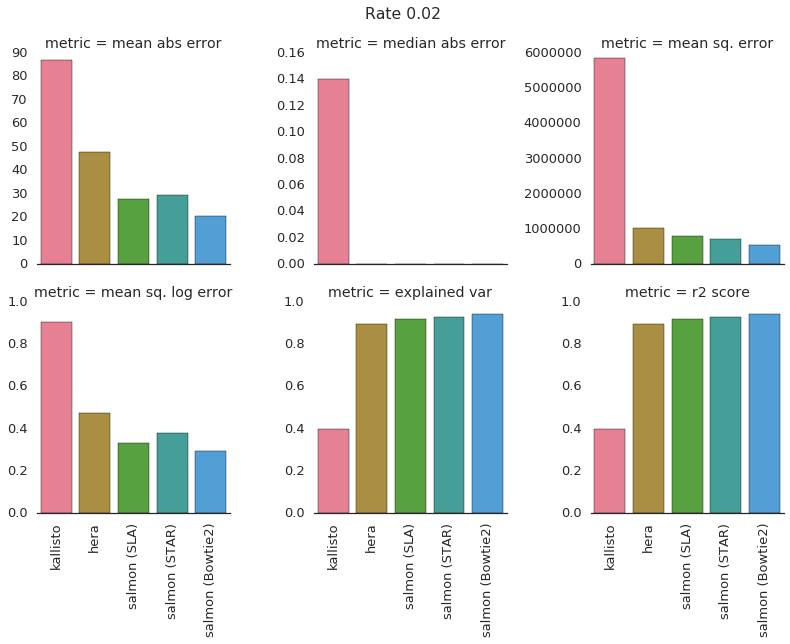

In [433]:
draw_mut_metrics(mut_metrics, 2, saveas='metrics_mut2.pdf')

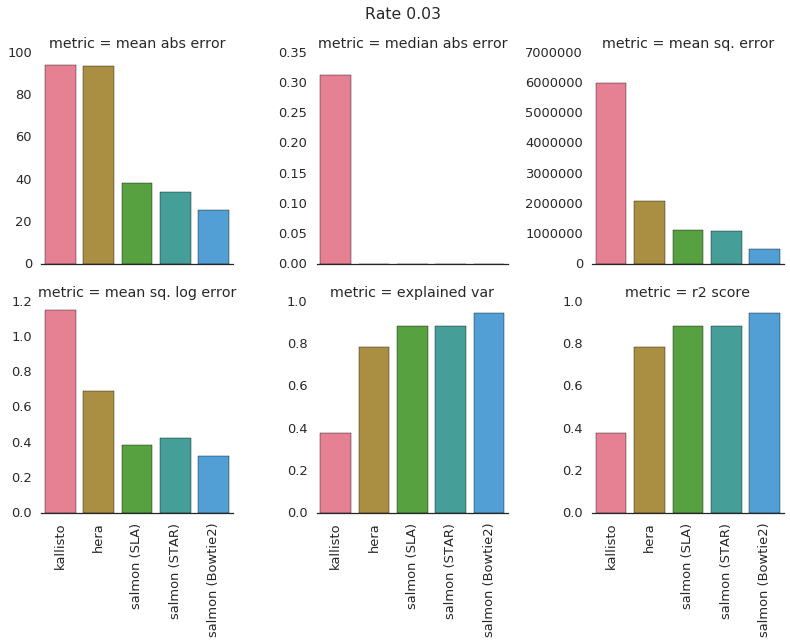

In [434]:
draw_mut_metrics(mut_metrics, 3, saveas='metrics_mut3.pdf')

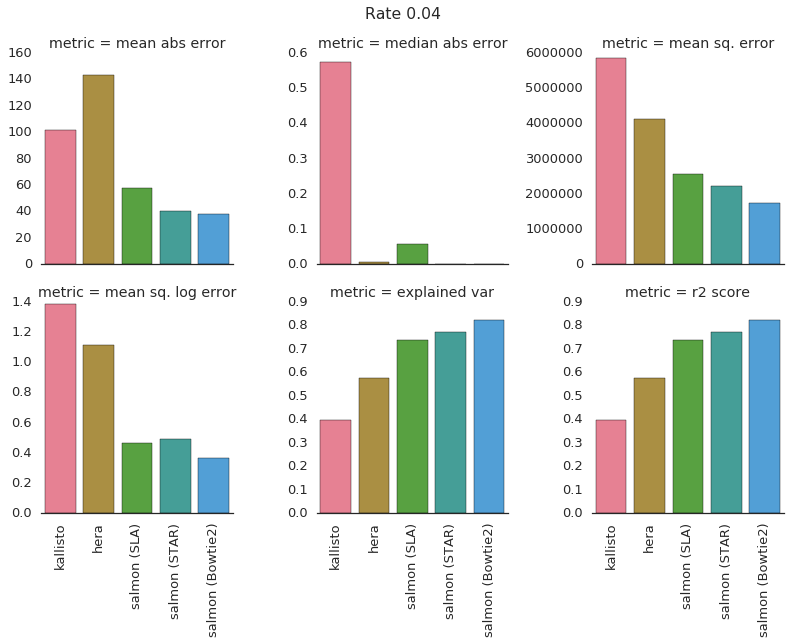

In [435]:
draw_mut_metrics(mut_metrics, 4, saveas='metrics_mut4.pdf')

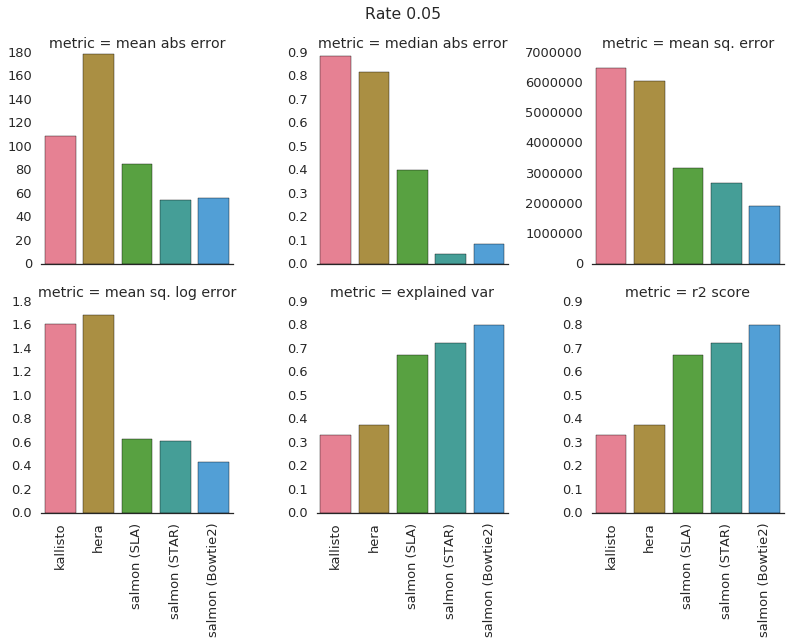

In [436]:
draw_mut_metrics(mut_metrics, 5, saveas='metrics_mut5.pdf')

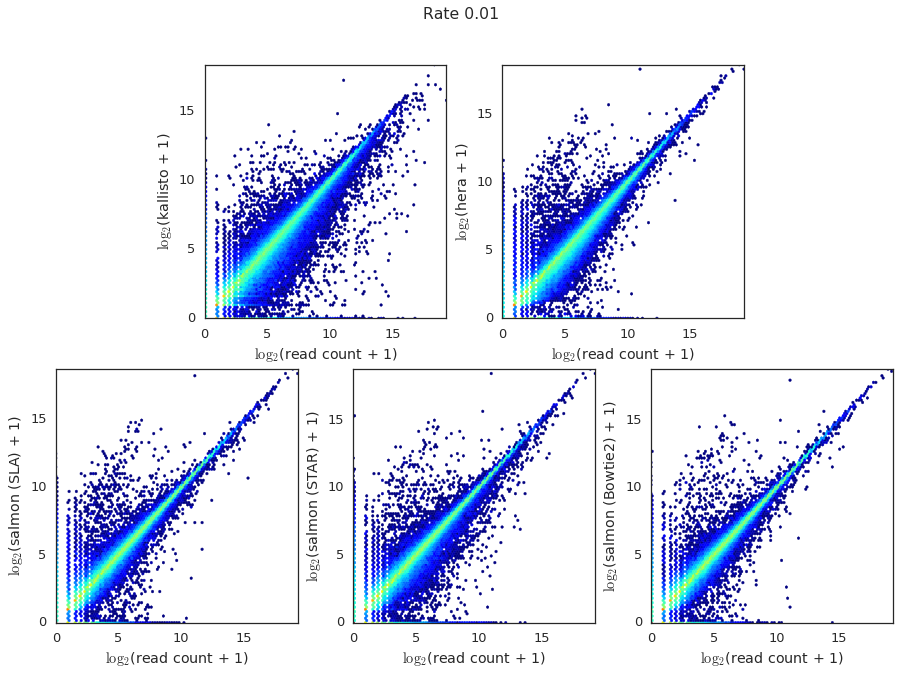

In [458]:
draw_mut_hexbins(mut_quants, 1, saveas='scatter_mut1.pdf')

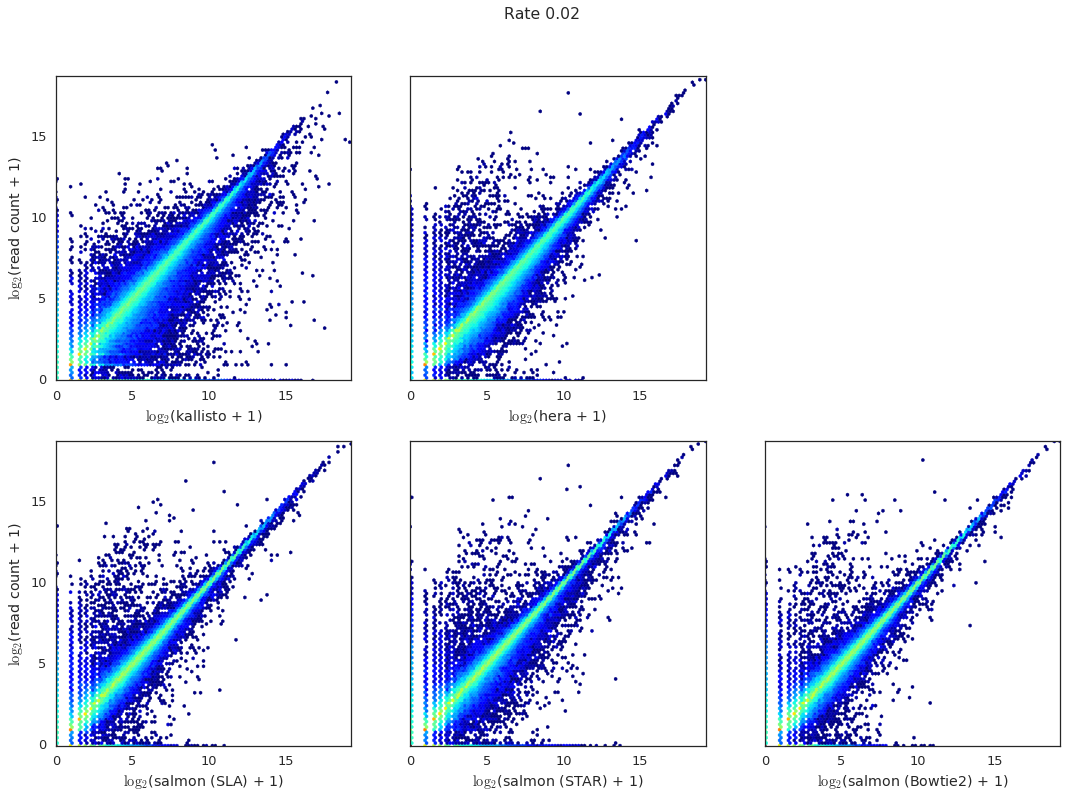

In [428]:
draw_mut_hexbins(mut_quants, 2, saveas='scatter_mut2.pdf')

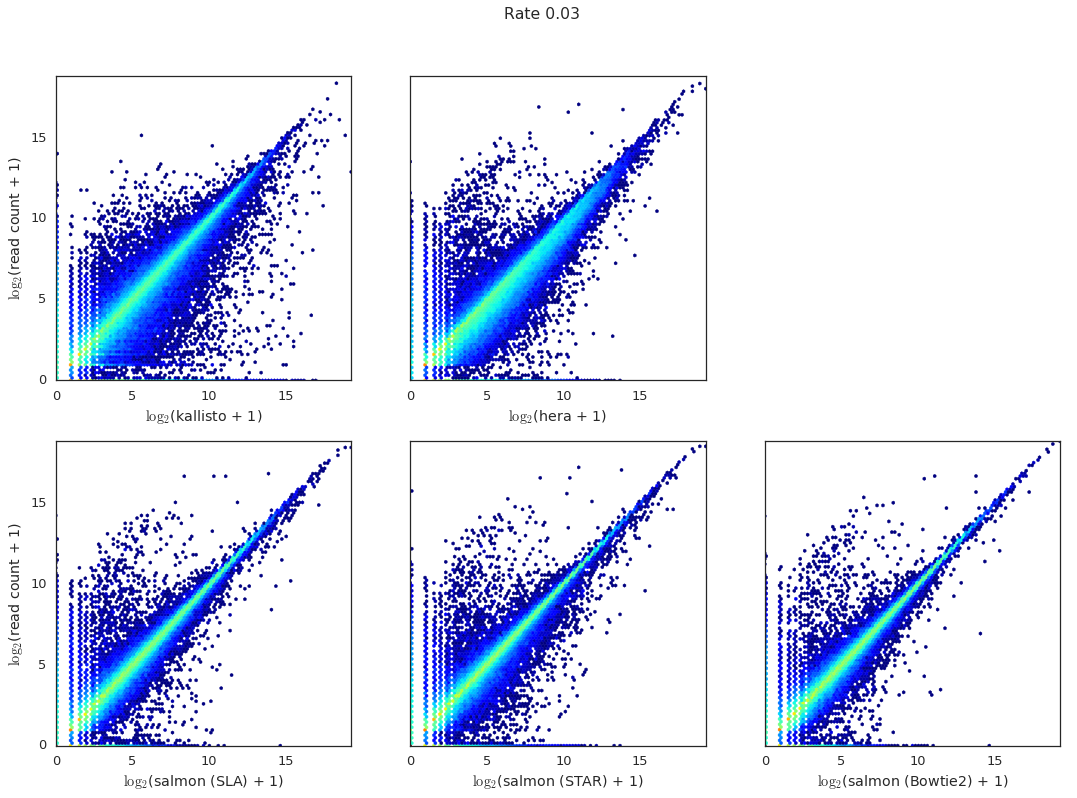

In [429]:
draw_mut_hexbins(mut_quants, 3, saveas='scatter_mut3.pdf')

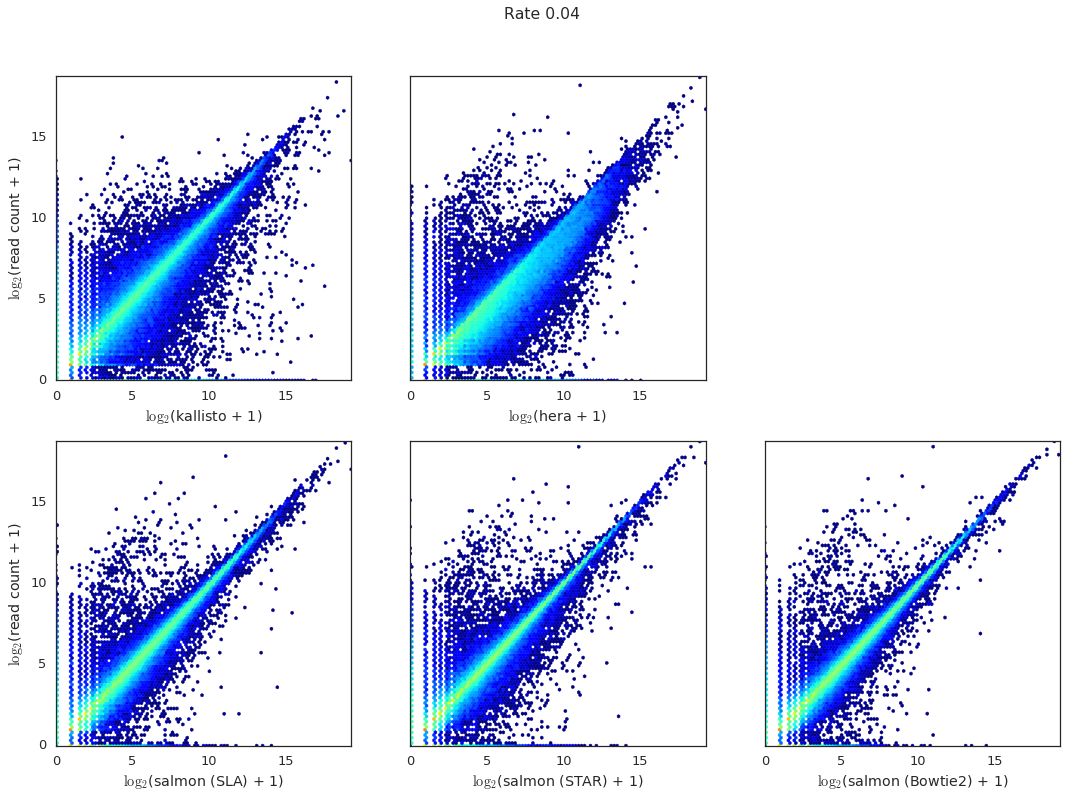

In [430]:
draw_mut_hexbins(mut_quants, 4, saveas='scatter_mut4.pdf')

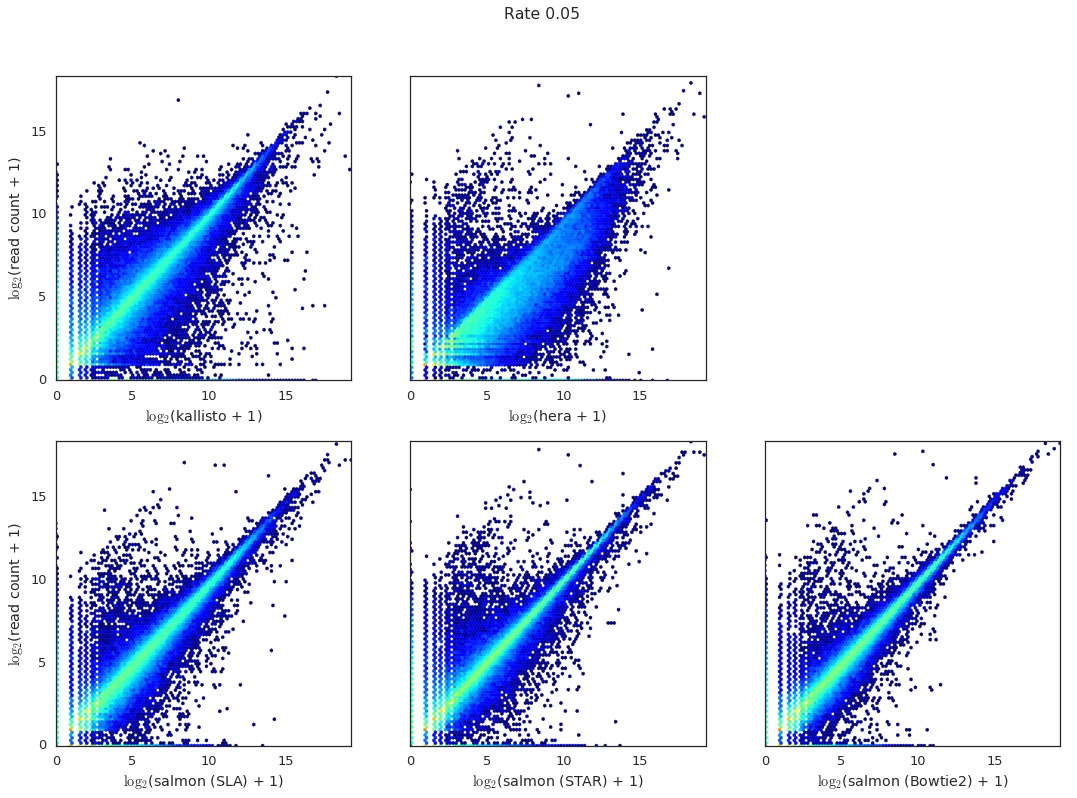

In [431]:
draw_mut_hexbins(mut_quants, 5, saveas='scatter_mut5.pdf')